# This song detector checks to see if there are high frequency oscillations in a recording to figure out if it has song. If there are high frequency oscillations, then it will use an amplitude threshold to check for song near the region of high frequency oscillation.

## Full periodicity pipeline for ONE recording:

### For parameter tuning:

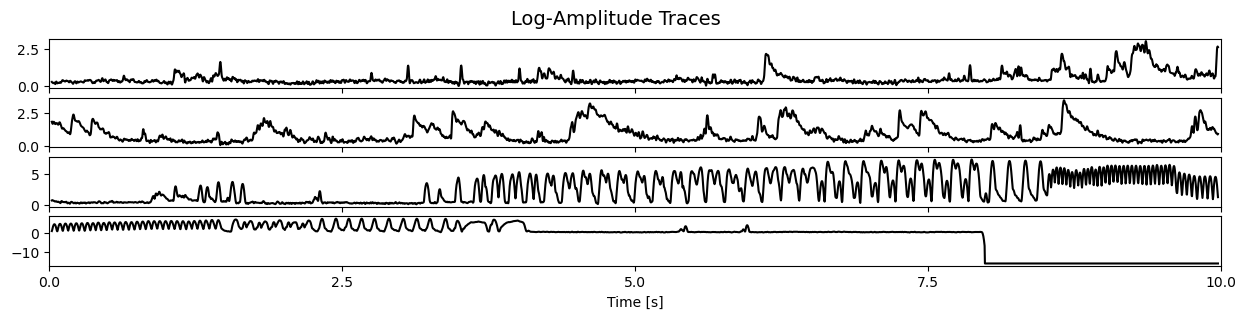

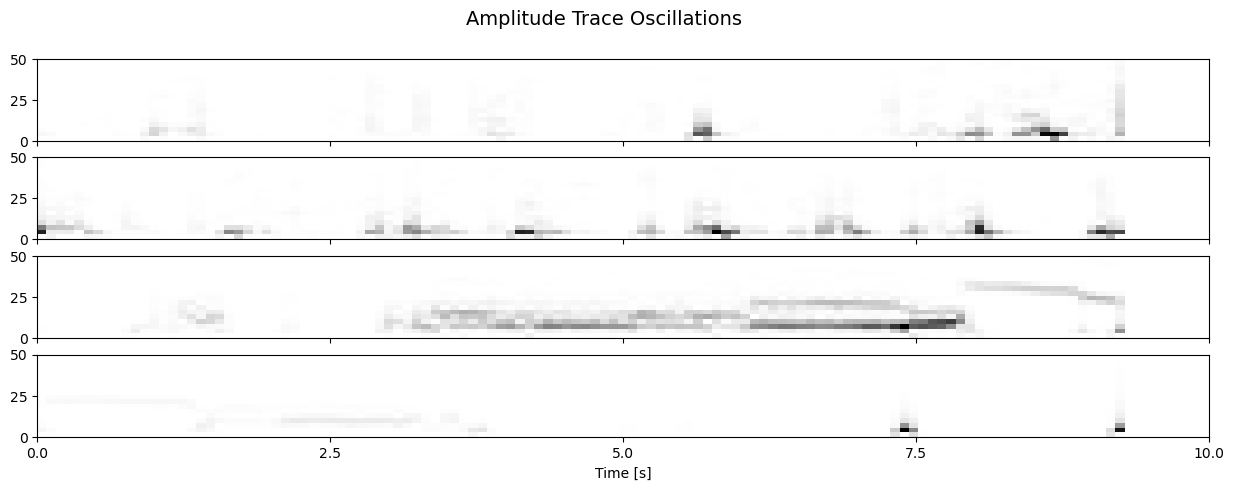

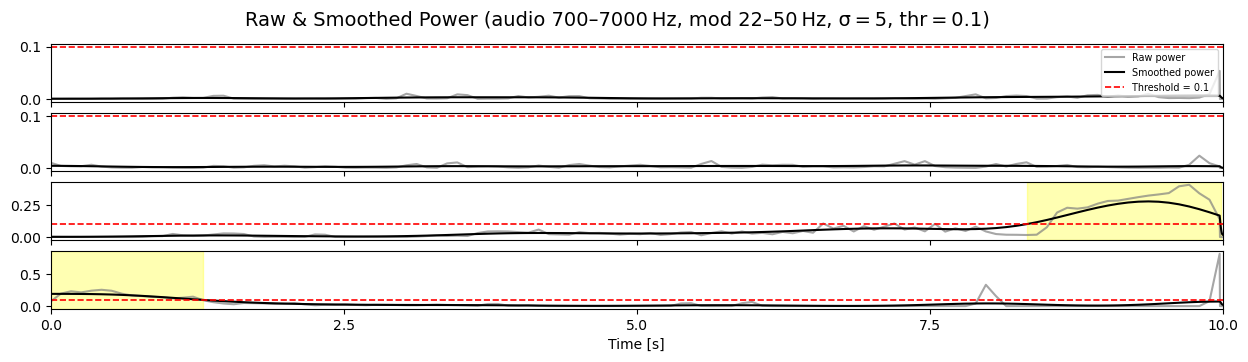

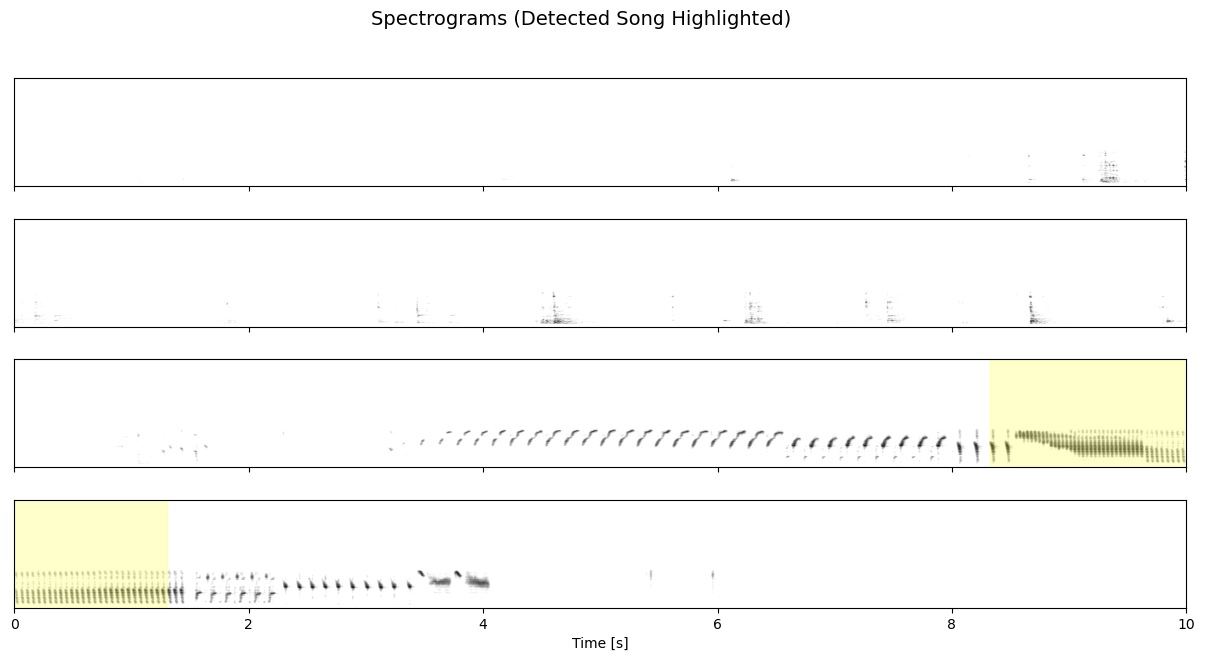

In [13]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-
"""
Visualise an audio file in stacked panels:
  • log‑amplitude trace
  • amplitude‑envelope modulation spectrogram
  • raw & smoothed modulation‑band power (with detections)
  • full audio spectrogram

User‑tunable parameters:
  ─ segment_duration     – seconds per panel
  ─ low_cut / high_cut   – audio band‑pass (Hz)
  ─ mod_low  / mod_high  – modulation‑frequency band for power (Hz)   <── NEW
  ─ smoothing_sigma      – Gaussian σ for smoothing the power trace
  ─ power_threshold      – detection threshold (same arbitrary units as power)
"""

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk


# ── Helper: screen size (≈100 dpi) ────────────────────────────────────────────
def get_screen_resolution():
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100


SCREEN_W, SCREEN_H = get_screen_resolution()


# ── Core routine ─────────────────────────────────────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: int = 10,
    low_cut: int = 500,
    high_cut: int = 8000,
    mod_low: int = 5,               # ── NEW ──
    mod_high: int = 50,             # ── NEW ──
    smoothing_sigma: float = 3,
    power_threshold: float = 0.5,
):
    """
    Visualise an audio file in multiple synced panels and highlight sections
    whose smoothed `mod_low–mod_high` Hz modulation power exceeds
    `power_threshold`.

    Raw power  = grey;  Smoothed power = black.
    The power figure is created before (and therefore appears before) the
    spectrogram figure.
    """
    try:
        # 1) Load & band‑pass filter ------------------------------------------------
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        b, a = ellip(
            5, 0.2, 40,
            [low_cut / (sr / 2), high_cut / (sr / 2)],
            btype="band"
        )
        data = filtfilt(b, a, data)

        # 2) Segment bookkeeping ----------------------------------------------------
        seg_len = segment_duration * sr
        n_segments = int(np.ceil(len(data) / seg_len))

        figs, axs = {}, {}

        # ---- order of creation matters for window stacking -----------------------
        figs["logA"],  axs["logA"]  = plt.subplots(
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
        )
        figs["amps"],  axs["amps"]  = plt.subplots(
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.5), sharex=True
        )
        figs["smooth"], axs["smooth"] = plt.subplots(          # <-- power first
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.35), sharex=True
        )
        figs["spec"],  axs["spec"]  = plt.subplots(            # <-- spec second
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.7), sharex=True
        )
        plt.subplots_adjust(hspace=0.3)

        # Ensure single‑segment cases behave the same
        for key in axs:
            if n_segments == 1:
                axs[key] = [axs[key]]

        # 3) Per‑segment processing -----------------------------------------------
        for i in range(n_segments):
            # ---- slice (zero‑pad last chunk) ------------------------------------
            start, end = i * seg_len, min((i + 1) * seg_len, len(data))
            segment = np.zeros(seg_len, dtype=data.dtype)
            segment[: end - start] = data[start:end]

            # ---- audio spectrogram ---------------------------------------------
            f, t, Sxx = spectrogram(
                segment, fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048, noverlap=2048 - 119
            )
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_norm = (np.clip(Sxx_log, -2, None) - Sxx_log.min()) / (Sxx_log.ptp())

            axs["spec"][i].imshow(
                Sxx_norm, cmap="binary", origin="lower", aspect="auto",
                extent=[0, segment_duration, f.min(), f.max()]
            )
            axs["spec"][i].set_yticks([])
            if i == n_segments - 1:
                axs["spec"][i].set_xlabel("Time [s]")

            # ---- log‑amplitude trace -------------------------------------------
            mask_audio = (f >= low_cut) & (f <= high_cut)
            log_amp = np.log10(np.sum(Sxx[mask_audio, :], axis=0) + np.finfo(float).eps)

            axs["logA"][i].plot(t, log_amp, color="black")
            axs["logA"][i].set_xlim(0, segment_duration)
            if i == n_segments - 1:
                axs["logA"][i].set_xlabel("Time [s]")
                axs["logA"][i].set_xticks(np.linspace(0, segment_duration, 5))
            else:
                axs["logA"][i].set_xticks([])

            # ---- amplitude‑trace spectrogram (padded) ---------------------------
            amp_fs = len(t) / segment_duration
            nper   = 128
            pad    = nper // 2
            padded = np.pad(
                log_amp,
                (pad, pad + int(segment_duration * amp_fs) - len(log_amp)),
                mode="constant"
            )
            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            if t_amp[-1] < segment_duration:
                extra = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra)), mode="constant")
                t_amp = np.concatenate([t_amp, t_amp[-1] + np.arange(1, extra + 1) / amp_fs])

            axs["amps"][i].imshow(
                Sxx_amp, cmap="binary", origin="lower", aspect="auto",
                extent=[0, segment_duration, f_amp.min(), f_amp.max()]
            )
            axs["amps"][i].set_ylim(0, mod_high)                  # updated
            axs["amps"][i].set_xlim(0, segment_duration)
            if i == n_segments - 1:
                axs["amps"][i].set_xlabel("Time [s]")
                axs["amps"][i].set_xticks(np.linspace(0, segment_duration, 5))
            else:
                axs["amps"][i].set_xticks([])

            # ---- modulation‑band power & smoothing -----------------------------
            mod_mask = (f_amp >= mod_low) & (f_amp <= mod_high)   # updated
            raw_pow  = np.sum(Sxx_amp[mod_mask, :], axis=0)
            smooth   = gaussian_filter1d(raw_pow, sigma=smoothing_sigma)

            # ---- combined power panel ------------------------------------------
            ax_p = axs["smooth"][i]
            ax_p.plot(t_amp, raw_pow,   color="grey",  alpha=0.7, label="Raw power")
            ax_p.plot(t_amp, smooth,    color="black",            label="Smoothed power")
            ax_p.axhline(power_threshold, color="red", ls="--", lw=1.2,
                         label=f"Threshold = {power_threshold}")
            ax_p.set_xlim(0, segment_duration)

            # Highlight detections
            detect = smooth > power_threshold
            if detect.any():
                in_span = False
                for j, flag in enumerate(detect):
                    if flag and not in_span:
                        in_span, t_start = True, t_amp[j]
                    elif not flag and in_span:
                        ax_p.axvspan(t_start, t_amp[j], color="yellow", alpha=0.3)
                        axs["spec"][i].axvspan(t_start, t_amp[j], color="yellow", alpha=0.2)
                        in_span = False
                if in_span:
                    ax_p.axvspan(t_start, segment_duration, color="yellow", alpha=0.3)
                    axs["spec"][i].axvspan(t_start, segment_duration, color="yellow", alpha=0.2)

            if i == n_segments - 1:
                ax_p.set_xlabel("Time [s]")
                ax_p.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax_p.set_xticks([])

            if i == 0:
                ax_p.legend(fontsize="x-small", loc="upper right")

        # 4) Figure titles --------------------------------------------------------
        figs["logA"].suptitle("Log‑Amplitude Traces", fontsize=14)
        figs["amps"].suptitle("Amplitude Trace Oscillations", fontsize=14)
        figs["smooth"].suptitle(
            f"Raw & Smoothed Power (audio {low_cut}–{high_cut} Hz, "
            f"mod {mod_low}–{mod_high} Hz, σ = {smoothing_sigma}, thr = {power_threshold})",
            fontsize=14
        )
        figs["spec"].suptitle("Spectrograms (Detected Song Highlighted)", fontsize=14)

        plt.show()

    except (OSError, ValueError) as err:
        print(f"Error processing {file_path}: {err}")


# ── Example usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FILE_PATH = (
     "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.52497071_4_8_14_34_57.wav"
    )

    plot_spectrograms_by_segment(
        FILE_PATH,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        mod_low=22,          # <── NEW: modulation band lower edge
        mod_high=50,         # <── NEW: modulation band upper edge
        smoothing_sigma=5,
        power_threshold=0.1,
    )


### For generating the .json file of detected songs:

In [8]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json


# ── Core detector ────────────────────────────────────────────────────────────
def detect_song_intervals(
    file_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    low_mod=10,              # ── NEW ──
    high_mod=40,             # ── NEW ──
    smoothing_sigma=3,
    power_threshold=0.5,
):
    """
    Detects [start_sec, end_sec] intervals where the smoothed `low_mod–high_mod`
    Hz modulation power of the log‑amplitude trace exceeds `power_threshold`.
    """
    try:
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:                    # stereo → mono
            data = data.mean(axis=1)

        # Band‑pass filter raw audio
        nyq = sr / 2
        b, a = ellip(5, 0.2, 40, [low_cut / nyq, high_cut / nyq], btype="band")
        data = filtfilt(b, a, data)

        seg_len_samples = int(segment_duration * sr)
        n_segments = int(np.ceil(len(data) / seg_len_samples))
        detected_intervals = []

        for i in range(n_segments):
            start_samp = i * seg_len_samples
            end_samp   = min(start_samp + seg_len_samples, len(data))
            segment = np.zeros(seg_len_samples, dtype=data.dtype)
            segment[: end_samp - start_samp] = data[start_samp:end_samp]

            # ── Audio‑spectrogram of segment ──────────────────────────────
            f, t, Sxx = spectrogram(
                segment,
                fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119,
            )

            # Log‑amplitude trace
            mask_audio_band = (f >= low_cut) & (f <= high_cut)
            amp_trace = np.sum(Sxx[mask_audio_band, :], axis=0)
            log_amp = np.log10(amp_trace + np.finfo(float).eps)

            # ── Spectrogram of amplitude trace (with full‑duration padding)
            amp_fs   = len(t) / segment_duration
            nper     = 128
            pad      = nper // 2
            exp_len  = int(segment_duration * amp_fs)

            log_amp_padded = np.pad(
                log_amp,
                (pad, pad + exp_len - len(log_amp)),
                mode="constant",
            )

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                log_amp_padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            # ── Ensure full‑width spectrogram ─────────────────────────────
            if t_amp[-1] < segment_duration:
                extra_cols = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                if extra_cols > 0:
                    Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra_cols)), mode="constant")
                    t_extra = t_amp[-1] + np.arange(1, extra_cols + 1) / amp_fs
                    t_amp   = np.concatenate((t_amp, t_extra))

            # ── Modulation‑band power envelope ───────────────────────────
            mask_mod_band = (f_amp >= low_mod) & (f_amp <= high_mod)  # NEW
            band_power    = np.sum(Sxx_amp[mask_mod_band, :], axis=0)
            smooth_pow    = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # ── Threshold‑based interval extraction ───────────────────────
            above = smooth_pow > power_threshold
            in_span = False
            for j, flg in enumerate(above):
                cur_time = i * segment_duration + t_amp[j]
                if flg and not in_span:
                    in_span  = True
                    span_start = cur_time
                elif not flg and in_span:
                    detected_intervals.append([span_start, cur_time])
                    in_span = False
            if in_span:  # ran off end of panel still above threshold
                detected_intervals.append([span_start, (i + 1) * segment_duration])

        return detected_intervals

    except Exception as err:
        print(f"⚠️  Error processing {file_path}: {err}")
        return []


# ── Folder‑level helper ───────────────────────────────────────────────────────
def process_folder(folder_path, output_json_path, **kwargs):
    results = {}
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            fpath = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            results[fname] = detect_song_intervals(fpath, **kwargs)

    with open(output_json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")


# ── Example usage ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FOLDER = (
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_debug_segmenter/sample_wav_files"
    )
    OUT_JSON = FOLDER + "_periodicity_only_detected_song_intervals.json"

    process_folder(
        FOLDER,
        OUT_JSON,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        low_mod=22,            # ← choose your modulation band here
        high_mod=55,          # ←
        smoothing_sigma=5,
        power_threshold=0.1,
    )

Processing: USA5510_45755.26006037_4_8_7_13_26.wav
Processing: USA5510_45755.26030477_4_8_7_13_50.wav
Processing: USA5510_45755.26071817_4_8_7_14_31.wav
Processing: USA5510_45755.26110762_4_8_7_15_10.wav
Processing: USA5510_45755.26270678_4_8_7_17_50.wav

Saved song detection results to: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files_periodicity_only_detected_song_intervals.json


## Full amplitude pipeline for ONE song for parameter tuning:

Screen size ≈ 15.1 × 9.8 inches
Segment 1: 🎵 Song detected
Segment 2: 🎵 Song detected


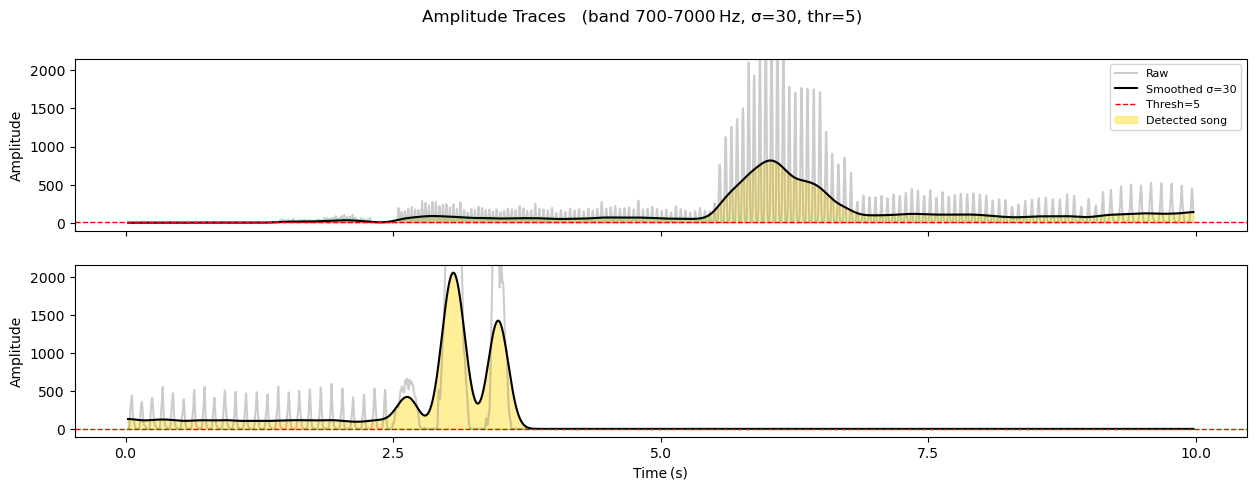

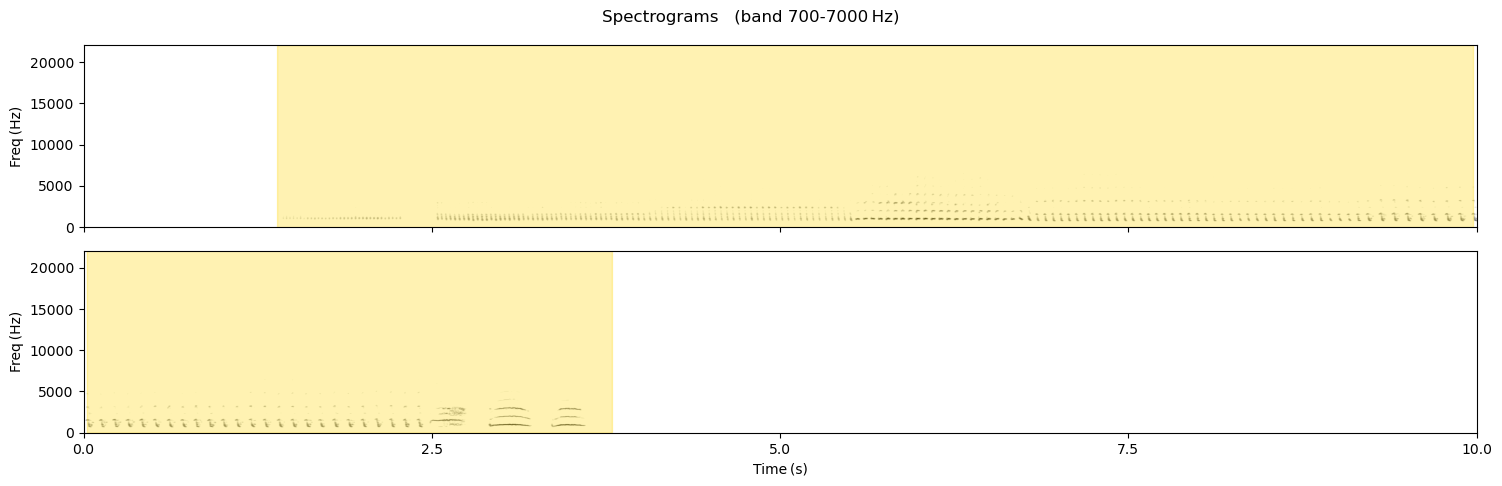

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path

# ------------------------------------------------------------
# Utility ── get screen size in inches (≈100 dpi assumption)
# ------------------------------------------------------------
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width  = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100   # inches

width_inches, height_inches = get_screen_resolution()
print(f"Screen size ≈ {width_inches:.1f} × {height_inches:.1f} inches")

# ------------------------------------------------------------
# Main visualisation routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05
    ):
    """
    Plot stacked amplitude traces and spectrograms for a WAV file, forcing all
    amplitude panels to share identical y‑axis limits.

    Parameters
    ----------
    file_path : str
        Path to the WAV file.
    segment_duration : float, default 10
        Seconds per panel (six panels = 1 min total).
    bandpass_filter_low_cut : float
        Lower edge of band‑pass filter (Hz).
    bandpass_filter_high_cut : float
        Upper edge of band‑pass filter (Hz).
    sigma : float, default 100
        σ (samples) for Gaussian smoothing of the amplitude trace.
    threshold : float, default 0.05
        Decision boundary applied to the smoothed trace.
    """
    try:
        # ---------- 1. Load audio ----------
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:                      # stereo → mono
            data = data.mean(axis=1)

        # ---------- 2. Band‑pass filter ----------
        nyquist = samplerate / 2
        wp      = [bandpass_filter_low_cut / nyquist,
                   bandpass_filter_high_cut / nyquist]
        b, a    = ellip(5, 0.2, 40, wp, btype='band')
        data    = filtfilt(b, a, data)

        # ---------- 3. Segment bookkeeping ----------
        segment_len  = int(segment_duration * samplerate)
        num_segments = int(np.ceil(len(data) / segment_len))

        # ---------- 4. Prepare figure stacks ----------
        fig1, axs_amp  = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        fig2, axs_spec = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        if num_segments == 1:      # keep iterable
            axs_amp  = [axs_amp]
            axs_spec = [axs_spec]

        # ---------- 5. Loop through segments ----------
        global_amp_min, global_amp_max = np.inf, -np.inf

        for i in range(num_segments):
            start = i * segment_len
            end   = start + segment_len
            seg   = np.zeros(segment_len, dtype=data.dtype)
            seg[:max(0, min(segment_len, len(data) - start))] = data[start:end]

            # ----- Spectrogram -----
            f, t, Sxx = spectrogram(
                seg,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )
            Sxx_log  = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log  = np.clip(Sxx_log, -2, None)
            Sxx_norm = ((Sxx_log - Sxx_log.min()) /
                        (Sxx_log.max() - Sxx_log.min()))

            # ----- Amplitude trace -----
            band_rows   = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
            amp_trace   = np.sum(Sxx[band_rows, :], axis=0)
            smooth_trace = gaussian_filter1d(amp_trace, sigma=sigma)
            is_song      = smooth_trace > threshold

            # Track global min/max for unified y‑axis
            global_amp_min = min(global_amp_min, smooth_trace.min())
            global_amp_max = max(global_amp_max, smooth_trace.max())

            # ----- Plot amplitude panel -----
            ax1 = axs_amp[i]
            ax1.plot(t, amp_trace,    color='gray',  alpha=0.4, label='Raw')
            ax1.plot(t, smooth_trace, color='black',           label=f'Smoothed σ={sigma}')
            ax1.axhline(threshold, color='red', linestyle='--', linewidth=1,
                        label=f'Thresh={threshold}')
            ax1.fill_between(t, smooth_trace, threshold, where=is_song,
                             color='gold', alpha=0.4,
                             label='Detected song' if i == 0 else None)
            ax1.set_ylabel('Amplitude')
            if i == 0:
                ax1.legend(fontsize=8, loc='upper right')
            if i == num_segments - 1:
                ax1.set_xlabel('Time (s)')
                ax1.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax1.set_xticks([])

            # ----- Plot spectrogram panel -----
            ax2 = axs_spec[i]
            ax2.imshow(Sxx_norm, aspect='auto', origin='lower',
                       extent=[0, segment_duration, f.min(), f.max()],
                       cmap='binary')
            ax2.fill_between(t, f.min(), f.max(), where=is_song,
                             color='gold', alpha=0.3)
            ax2.set_ylabel('Freq (Hz)')
            if i == num_segments - 1:
                ax2.set_xlabel('Time (s)')
                ax2.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax2.set_xticks([])

            # Console feedback
            status = "🎵 Song detected" if np.any(is_song) else "⚪ No song"
            print(f"Segment {i+1}: {status}")

        # ---------- 6. Apply common y‑limits ----------
        pad = 0.05 * (global_amp_max - global_amp_min or 1)
        common_ylim = (global_amp_min - pad, global_amp_max + pad)
        for ax in axs_amp:
            ax.set_ylim(common_ylim)

        # ---------- 7. Titles & layout ----------
        bp_range = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
        fig1.suptitle(f'Amplitude Traces   (band {bp_range}, σ={sigma}, thr={threshold})',
                      fontsize=12)
        fig2.suptitle(f'Spectrograms   (band {bp_range})', fontsize=12)
        plt.tight_layout()
        plt.show()

    except ValueError as err:
        print(f"[ERROR] {file_path}: {err}")

# ------------------------------------------------------------
# Example call – replace with your own WAV
# ------------------------------------------------------------
if __name__ == "__main__":
    example_wav = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.52497071_4_8_14_34_57.wav")  # ⇦ change me!
    if example_wav.exists():
        plot_spectrograms_by_segment(
            file_path=str(example_wav),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=5
        )
    else:
        print(f"Example WAV not found: {example_wav}")


### Generate the .json file: